## Time-series model iteration

In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from data_ingestor import *
from time_series import *

plt.style.use('seaborn')
%matplotlib inline

In [2]:
path_to_json = "/Users/shivamsolanki/Desktop/Study/AI_workflow_coursera/ai-workflow-capstone/cs-train/"
column_dict ={'country': 'country', 'customer_id': 'customer_id',
                       'day': 'day','invoice': 'invoice', 'month': 'month',
                       'total_price': 'price', 'StreamID': 'stream_id',
                        'TimesViewed': 'times_viewed'}
inconsistent_col = ['TimesViewed', 'StreamID', 'total_price']
keys=['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']

In [34]:
df_total = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
df_clean = maintain_datatype(df_total)
df_clean = drop_non_numeric_invoice(df_clean)
df_day = df_clean.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day = create_date_col(df_day)
df_day = df_day[df_day['price']<=20000]
df_day.head()

(815011, 9)


,year,month,day,times_viewed,price,country,Date
0,2017,11,28,14841,13979.67,United Kingdom,2017-11-28
1,2017,11,29,14121,13201.65,United Kingdom,2017-11-29
2,2017,11,30,15673,11145.50,United Kingdom,2017-11-30
3,2017,12,1,12461,9512.81,United Kingdom,2017-12-01
4,2017,12,2,3313,1443.26,United Kingdom,2017-12-02


In [35]:
ts = df_day[['price', 'Date']].set_index('Date') # Set Date as index
ts = ts['price']

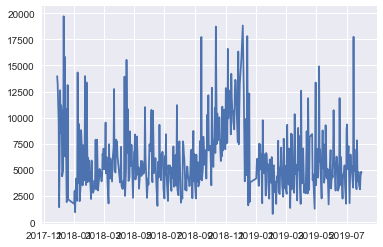

In [36]:
plt.plot(ts)


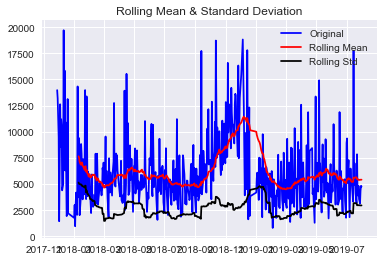

Results of Dickey-Fuller Test:
Test Statistic                  -3.500937
p-value                          0.007963
#Lags Used                      10.000000
Number of Observations Used    474.000000
Critical Value (1%)             -3.444221
Critical Value (5%)             -2.867657
Critical Value (10%)            -2.570028
dtype: float64


In [37]:
test_stationarity(ts)

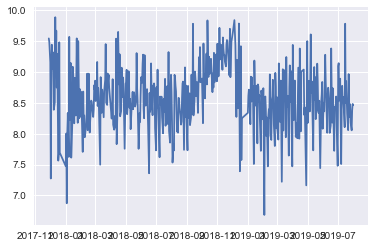

In [38]:
ts_log = np.log(ts)
plt.plot(ts_log)

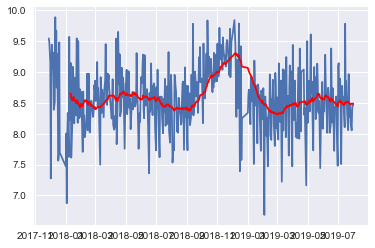

In [39]:
moving_avg = ts_log.rolling(30).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [40]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(30)

Date
2017-11-28         NaN
2017-11-29         NaN
2017-11-30         NaN
2017-12-01         NaN
2017-12-02         NaN
2017-12-03         NaN
2017-12-04         NaN
2017-12-05         NaN
2017-12-06         NaN
2017-12-07         NaN
2017-12-08         NaN
2017-12-10         NaN
2017-12-11         NaN
2017-12-12         NaN
2017-12-13         NaN
2017-12-14         NaN
2017-12-15         NaN
2017-12-17         NaN
2017-12-18         NaN
2017-12-19         NaN
2017-12-20         NaN
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-07         NaN
2018-01-08         NaN
2018-01-09         NaN
2018-01-10    0.411324
Name: price, dtype: float64

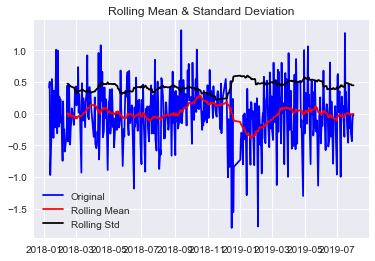

Results of Dickey-Fuller Test:
Test Statistic                  -4.505777
p-value                          0.000192
#Lags Used                      11.000000
Number of Observations Used    444.000000
Critical Value (1%)             -3.445164
Critical Value (5%)             -2.868072
Critical Value (10%)            -2.570249
dtype: float64


In [41]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

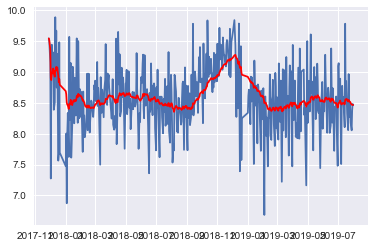

In [42]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

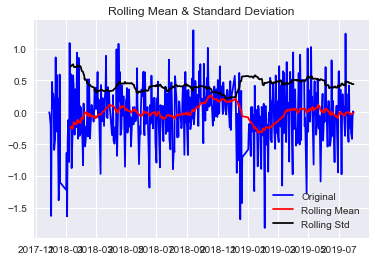

Results of Dickey-Fuller Test:
Test Statistic                -6.570652e+00
p-value                        7.951838e-09
#Lags Used                     8.000000e+00
Number of Observations Used    4.760000e+02
Critical Value (1%)           -3.444163e+00
Critical Value (5%)           -2.867631e+00
Critical Value (10%)          -2.570014e+00
dtype: float64


In [43]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

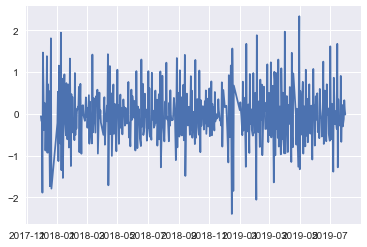

In [44]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

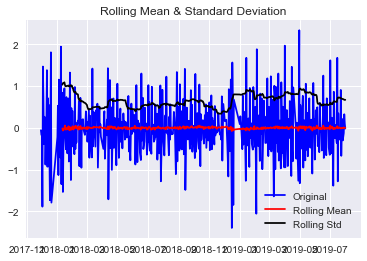

Results of Dickey-Fuller Test:
Test Statistic                -8.300973e+00
p-value                        4.019389e-13
#Lags Used                     1.600000e+01
Number of Observations Used    4.670000e+02
Critical Value (1%)           -3.444431e+00
Critical Value (5%)           -2.867749e+00
Critical Value (10%)          -2.570077e+00
dtype: float64


In [45]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [46]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

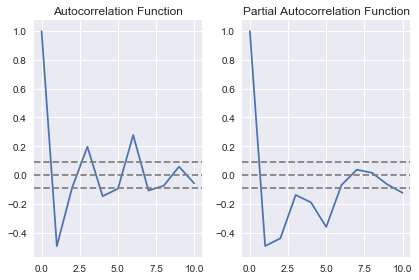

In [47]:
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [48]:
# ts = make_continuous(df_day)
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)


In [50]:
from statsmodels.tsa.arima_model import ARIMA


##### AR model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: nan')

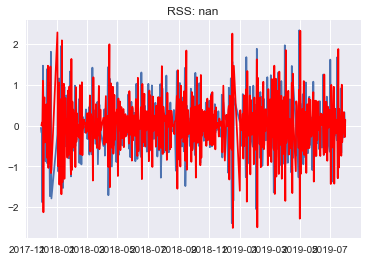

In [149]:
model = ARIMA(ts_log_diff, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

##### MA Model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 115.7896')

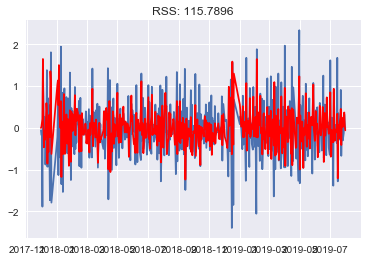

In [132]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#### Combined model ARIMA

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 114.9252')

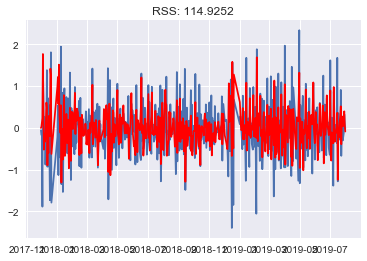

In [129]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [139]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2017-11-30    0.000271
2017-12-01    0.071541
2017-12-02   -0.006479
2017-12-03    1.096526
2017-12-04   -2.127672
dtype: float64


In [140]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2017-11-30    0.000271
2017-12-01    0.071812
2017-12-02    0.065332
2017-12-03    1.161859
2017-12-04   -0.965813
dtype: float64


In [150]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2017-11-28    9.545359
2017-11-29    9.545359
2017-11-30    9.545631
2017-12-01    9.617171
2017-12-02    9.610692
dtype: float64

Text(0.5, 1.0, 'RMSE: 13216.8976')

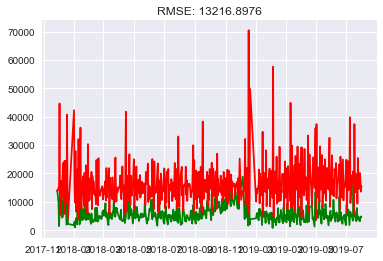

In [156]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, color='green')
plt.plot(predictions_ARIMA, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [145]:
predictions_ARIMA.tail()

Date
2019-07-26    14575.381317
2019-07-28    20176.831371
2019-07-29    18040.267988
2019-07-30    13573.286647
2019-07-31    15644.532998
dtype: float64

In [147]:
ts.head()

Date
2017-11-28    13979.67
2017-11-29    13201.65
2017-11-30    11145.50
2017-12-01     9512.81
2017-12-02     1443.26
Name: price, dtype: float64